### ISIC-2018 dataset for this task is obtained from the link below,
### https://challenge.isic-archive.com/data/ 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras

In [ ]:
kaggle = True

In [ ]:
import glob

img_size = 256
batch_size = 32

base_path = "../input/isic2018-challenge-task1-data-segmentation" if kaggle else "/content"

train_path = base_path + "/ISIC2018_Task1-2_Training_Input/*.jpg"
val_path = base_path + "/ISIC2018_Task1-2_Validation_Input/*.jpg"
val_groundtruth = "../input/cacheforisic2018/ISIC2018_Task1_Validation_GroundTruth/*.png" if kaggle else base_path + "/ISIC2018_Task1_Validation_GroundTruth/*.png" 
test_path = base_path + "/ISIC2018_Task1-2_Test_Input/*.jpg"
train_groundtruth = base_path + "/ISIC2018_Task1_Training_GroundTruth/*.png"

In [ ]:
train_paths = glob.glob(train_path)
val_paths = glob.glob(val_path)
val_ypaths = glob.glob(val_groundtruth)
test_paths = glob.glob(test_path)
train_ypaths = glob.glob(train_groundtruth)

train_paths.sort()
val_paths.sort()
val_ypaths.sort()
test_paths.sort()
train_ypaths.sort()

In [ ]:
train_percentage = len(train_paths)/(len(train_paths) + len(test_paths) + len(val_paths))
val_percentage = len(val_paths)/(len(train_paths) + len(test_paths) + len(val_paths))
test_percentage = len(test_paths)/(len(train_paths) + len(test_paths) + len(val_paths))

print("validation \t%:", 100*val_percentage, "\ntrain \t\t%:", 100*train_percentage, "\ntest \t\t%:", 100*test_percentage)

validation 	%: 2.707092582566324 
train 		%: 70.22198159177044 
test 		%: 27.070925825663238


How the set is split seems kinda awkward given that the % validation size is very low. Could try to mix with train set and get a bigger sample if results won't satisfy.

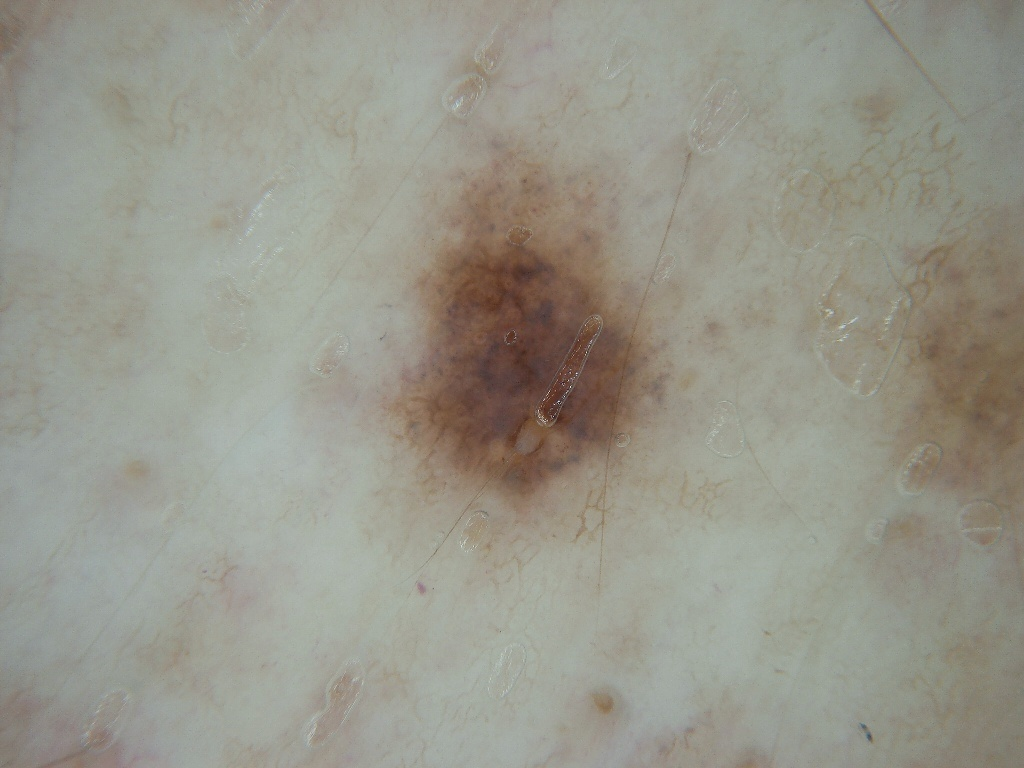

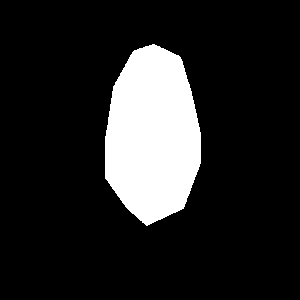

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
def display_sample():
    display(Image(filename=train_paths[727], width=300, height=300))
    img = PIL.ImageOps.autocontrast(load_img(train_ypaths[727], target_size=(300, 300)))
    display(img)
    
display_sample()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.0)
val_datagen = ImageDataGenerator(rescale=1/255.0)

train = pd.DataFrame(train_paths, columns = ['paths'])
train_y = pd.DataFrame(train_ypaths, columns = ['paths'])
val = pd.DataFrame(val_paths, columns = ['paths'])
val_y = pd.DataFrame(val_ypaths, columns = ['paths'])
test = pd.DataFrame(test_paths, columns = ['paths'])

In [ ]:
train_set = train_datagen.flow_from_dataframe(dataframe = train,
                                              x_col="paths",
                                              class_mode=None,
                                              batch_size = batch_size,
                                              shuffle=False,
                                              target_size = (img_size,img_size))

train_set_y = train_datagen.flow_from_dataframe(dataframe = train_y,
                                              x_col="paths",
                                              class_mode=None,
                                              batch_size = batch_size,
                                              shuffle=False,
                                              target_size = (img_size,img_size))

val_set = val_datagen.flow_from_dataframe(dataframe = val,
                                              x_col="paths",
                                              class_mode=None,
                                              batch_size = batch_size,
                                              shuffle=False,
                                              target_size = (img_size,img_size))

val_set_y = val_datagen.flow_from_dataframe(dataframe = val_y,
                                              x_col="paths",
                                              class_mode=None,
                                              batch_size = batch_size,
                                              shuffle=False,
                                              target_size = (img_size,img_size))

test_set = val_datagen.flow_from_dataframe(dataframe = test,
                                              x_col="paths",
                                              class_mode=None,
                                              batch_size = batch_size,
                                              shuffle=False,
                                              target_size = (img_size,img_size))

Found 2594 validated image filenames.
Found 2594 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.
Found 1000 validated image filenames.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, UpSampling2D
from tensorflow.keras import Model

# u-net implementation for image segmentation (1 layer from the original paper is absent because of the huge model size.)
def get_model(img_size, out_channels):
    inputs = Input((img_size, img_size, 3))

    k = (3, 3)
    p = (2, 2)
    u = (2, 2)

    conv1 = Conv2D(64, k, activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(64, k, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
    pool1 = MaxPooling2D(p)(conv1)
    # downsample 1

    conv2 = Conv2D(128, k, activation='relu', kernel_initializer='he_normal', padding='same') (pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(128, k, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
    pool2 = MaxPooling2D(p)(conv2)
    # downsample 2

    conv3 = Conv2D(256, k, activation='relu', kernel_initializer='he_normal', padding='same') (pool2)
    conv3 = Dropout(0.1)(conv3)
    conv3 = Conv2D(256, k, activation='relu', kernel_initializer='he_normal', padding='same') (conv3)
    pool3 = MaxPooling2D(p)(conv3)
    # downsample 3
    
    conv4 = Conv2D(512, k, activation='relu', kernel_initializer='he_normal', padding='same') (pool3)
    conv4 = Dropout(0.1)(conv4)
    conv4 = Conv2D(512, k, activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
    pool4 = MaxPooling2D(p)(conv4)
    # downsample 4
    
    conv5 = Conv2D(1024, k, activation='relu', kernel_initializer='he_normal', padding='same') (pool4)
    conv5 = Dropout(0.1)(conv5)
    conv5 = Conv2D(1024, k, activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
    conv5 = UpSampling2D(u, interpolation="nearest") (conv5)
    # downsample 5
    
    up_conv4 = concatenate([conv4, conv5], axis=3)
    up_conv4 = Conv2D(512, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv4)
    up_conv4 = Dropout(0.1)(up_conv4)
    up_conv4 = Conv2D(256, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv4)
    up_conv4 = UpSampling2D(u, interpolation="nearest") (up_conv4)
    # upsample 4

    up_conv3 = concatenate([conv3, up_conv4], axis=3)
    up_conv3 = Conv2D(512, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv3)
    up_conv3 = Dropout(0.1)(up_conv3)
    up_conv3 = Conv2D(256, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv3)
    up_conv3 = UpSampling2D(u, interpolation="nearest") (up_conv3)
    # upsample 3

    up_conv2 = concatenate([conv2, up_conv3], axis=3)
    up_conv2 = Conv2D(256, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv2)
    up_conv2 = Dropout(0.1)(up_conv2)
    up_conv2 = Conv2D(128, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv2)
    up_conv2 = UpSampling2D(u, interpolation="nearest") (up_conv2)
    # upsample 2

    up_conv1 = concatenate([conv1, up_conv2], axis=3)
    up_conv1 = Conv2D(128, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv1)
    up_conv1 = Conv2D(64, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv1)
    up_conv1 = Conv2D(64, k, activation='relu', kernel_initializer='he_normal', padding='same') (up_conv1)
    up_conv1 = Conv2D(2, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (up_conv1)
    # upsample 1

    outputs = Conv2D(out_channels, (1, 1), activation='sigmoid') (up_conv2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from tensorflow.keras.models import load_model

kaggle = True
try:
    loaded_model = load_model("../input/saved-model/saved_models") if kaggle else load_model("/content/drive/MyDrive/Colab_Notebooks/saved_models/")
    saved_model = True
except:
    saved_model = False

In [ ]:
out_channels = 1

keras.backend.clear_session()

model = loaded_model if saved_model else get_model(img_size, out_channels)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.math import exp

def scheduler(epoch, lr):
    return lr * exp(-0.06) # around 0.98

callbacks = list()
callbacks.append(EarlyStopping(monitor="loss", min_delta=1e-3, patience=2, verbose=1))
callbacks.append(LearningRateScheduler(scheduler, verbose=1))
filepath = "./saved_models/" if kaggle else "/content/drive/MyDrive/Colab_Notebooks/saved_models"
callbacks.append(ModelCheckpoint(filepath=filepath, monitor="loss", save_best_only=True, save_freq="epoch"))

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

2022-05-15 16:43:54.389480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:54.390348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:54.391030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:54.391829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:43:54.392599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [ ]:
val_steps = len(val) // batch_size
steps_per_epoch = len(train) // batch_size
val_steps, steps_per_epoch

(3, 81)

In [ ]:
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(learning_rate=6e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

hist = model.fit(zip(train_set, train_set_y), epochs=4, verbose=1, 
                 steps_per_epoch=steps_per_epoch, validation_steps=val_steps,
                 validation_data=zip(val_set, val_set_y), callbacks=callbacks)

In [ ]:
test_preds = loaded_model.predict(test_set, verbose=1)

32/32 [==============================] - 181s 6s/step


In [ ]:
val_preds = loaded_model.predict(val_set, verbose=1)

4/4 [==============================] - 14s 2s/step


In [ ]:
val_mean, test_mean = val_preds.mean(), test_preds.mean()
print(val_mean, test_mean)
val_std, test_std = val_preds.std(), test_preds.std()
print(val_std, test_std)

0.33200195 0.33374164
0.3459716 0.34111226


In [ ]:
test_preds1 = np.where(test_preds<test_std, 0, 1)
val_preds1 = np.where(test_preds<val_std, 0, 1)

In [ ]:
import matplotlib.pyplot as plt
import cv2

def grid_mask_test(start_idx, row, testing=True):
    f, axarr = plt.subplots(row, 3 if testing else 4)
    f.set_figheight(16)
    f.set_figwidth(10)
    for i in range(row):
        for j in range(3):
            if j == 0:
                axarr[i, j].imshow(cv2.imread(test["paths"][start_idx+i])) if testing else axarr[i,j].imshow(cv2.imread(val["paths"][start_idx+i]))
                axarr[i, j].set_title('sample')
            
            elif j == 1:
                axarr[i, j].imshow(test_preds1[start_idx+i], cmap='gray') if testing else axarr[i,j].imshow(val_preds1[start_idx+i], cmap='gray')
                axarr[i, j].set_title('prediction')
            else:
                axarr[i, j].imshow(test_preds[start_idx+i], cmap='gray') if testing else axarr[i,j].imshow(val_preds[start_idx+i], cmap='gray')
                axarr[i, j].set_title('prediction-unfiltered')
        
        if not testing:
            axarr[i, 3].imshow(cv2.imread(val_y["paths"][start_idx+i]))
            axarr[i, 3].set_title('label')

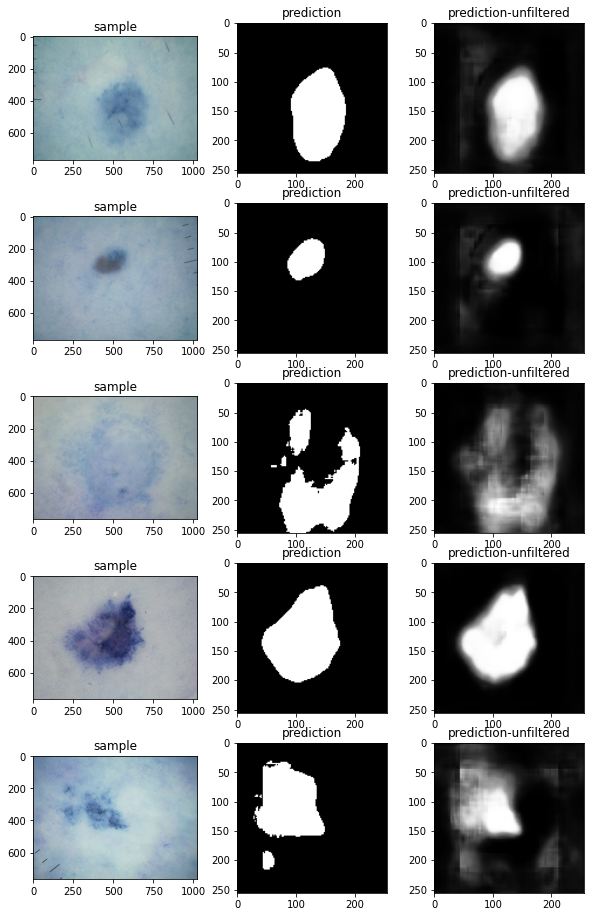

In [ ]:
grid_mask_test(15, 5)

I think we can observe here that some examples need a better treshold.

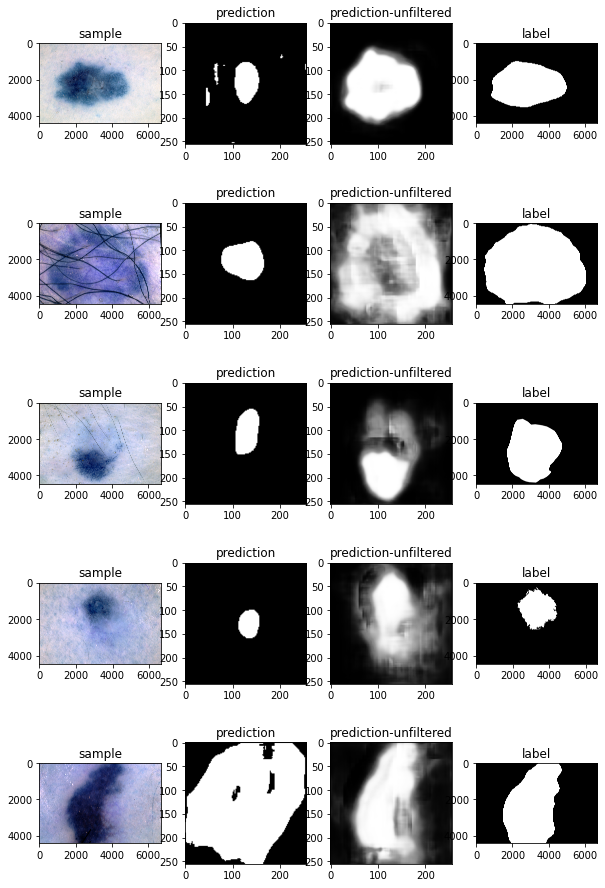

In [ ]:
grid_mask_test(10, 5, testing=False)

In [ ]:
val_set_y = val_datagen.flow_from_dataframe(dataframe = val_y,
                                              x_col="paths",
                                              class_mode=None,
                                              batch_size = len(val_y),
                                              shuffle=False,
                                              target_size = (img_size,img_size))

val_set_y = next(val_set_y)

Found 100 validated image filenames.


In [ ]:
val_set_y.shape, val_preds1.shape

((100, 256, 256, 3), (1000, 256, 256, 1))

In [ ]:
# IOU hesabını yetiştiremedim modeli eğitmeye odaklanmaktan.